<a href="https://colab.research.google.com/github/nedokormysh/Stepik_Competitive_DS/blob/week_6/solution_6_4_1_%2B%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Условие

**Задача: Обучи модели для блендинга и стекинга, выбери лучшие**

Датасеты: quickstart_train.csv и quickstart_test.csv.

Регрессионный таргет: столбец target_reg , метрика RMSE.

Для блендинга и стекинга выбрать 3 модели:

Любые 2 бустинга на ваш выбор.
Любую другую модель (не бустинг).
Для стекинга в качестве метамодели желательно взять простой алгоритм (регрессию, KNN и т. п.).

Далее реализуем блендинг и стекинг и делаем финальное предсказание:

* можно выбрать предсказание от блендинга;
* можно от стекинга;
* можно ансамбль блендинга и стекинга;
* можно блендинг блендинга и стекинга с весами 🙈.

**Дополнительные условия:**

Особенно ничем вас не ограничиваем, можно пользоваться всем арсеналом: подбирать гиперпараметры в Optuna, генерить\отбирать признаки и т. п. Но желательно сосредоточиться на освоении блендинга со стекингом и подбором моделей для них.
Сохраняем в submission.csv только колонки car_id и target_reg.
В конце добавляем выводы о проделанных экспериментах, что зашло\не зашло.
Желательно, чтобы на выполнение всего ноутбука уходило не более 30 мин.

**Критерии оценки (максимум 10 баллов за задание):**

*Оформление (3 балла)*

прослеживается логика в последовательности решения задачи; в неочевидных местах добавлены поясняющие комментарии и маркдаун ячейки; ноутбук не перегружен лишней информацией, огромными простынями аутпутов ячеек (настраиваем verbose, скрываем служебную информацию после установки библиотек);
хороший codestyle: код соответствует PEP 8 и DRY, названия переменных и функций понятны либо соответствуют общепринятым нормам (train, test, model, pd, xgb и т. п.);
в конце присутствуют выводы о проделанных экспериментах.

*Решение задачи и выполнение доп. условий (3 балла)*

ноутбук выполняется до конца без ошибок (присутствуют все аутпуты в пдф);
реализованы блендинг со стекингом и выполнены доп. условия;
проведена работа над воспроизводимостью (зафиксированы все random seeds).

*Использование возможностей фреймворка (2 балла)*

корректная подготовка данных для использования в ансамбле;
используется early_stopping, многопоточность (n_threads) и пр.;
правильная подготовка категориальных признаков для каждой модели;
корректное использование пайплайнов и функций sklearn или другой библиотеки.

*Дополнительные баллы (макс. 2 балла)*

* 1 балл, если проводился подбор гиперпараметров;
* 1 балл, если использованы минимум 2 вида графики, и на основе их сделаны какие-либо выводы (не просто график ради красивой картинки, а с пользой для дела);
* 1 балл, если для ансамблей использовались библиотеки, не затронутые или кратко упомянутые в уроках (pystacknet и пр.);
* 1 балл, если использовались ансамблевые методы, не затронутые в уроках (стекинг с фичами, стекинг с весами и пр.).

In [16]:
!pip install catboost -q
!pip install pytorch-tabnet -q
!pip install optuna -q
!pip install gerrychain -q
# !pip install lightgbm -q
# !pip install xgboost -q

# Загрузка библиотек

In [17]:
from typing import Any
import re

from gerrychain.random import random

import pandas as pd
import numpy as np
import seaborn as sns

import optuna
from optuna.integration import CatBoostPruningCallback, LightGBMPruningCallback, XGBoostPruningCallback
# optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping, Dataset
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import NuSVR

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import copy

import pickle
import warnings
warnings.simplefilter('ignore')

import os
import platform
import psutil

In [18]:
# фиксируем random state согласно инструкции для optuna
!export PYTHONHASHSEED=0
random.seed(7575)

In [19]:
# print(platform.system(), platform.processor())
# # print(os.uname())
# print('CPU count:', os.cpu_count())
# print('RAM (GB):', psutil.virtual_memory()[0]/1000000000)
# print('RAM memory % used:', psutil.virtual_memory()[2])
# !python -V

# Загрузка данных

In [20]:
PATH_TRAIN = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv'
PATH_TEST = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv'

## Оптимизируем объём памяти.

In [21]:
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

def import_data(file: str)-> pd.DataFrame:
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [22]:
print('train')
train = import_data(PATH_TRAIN)

print('-' * 80)
print('test')
test = import_data(PATH_TEST)

train
Memory usage of dataframe is 0.30 MB
Memory usage after optimization is: 0.16 MB
Decreased by 47.7%
--------------------------------------------------------------------------------
test
Memory usage of dataframe is 0.23 MB
Memory usage after optimization is: 0.14 MB
Decreased by 40.9%


## Подготовка данных

array([[<Axes: title={'center': 'car_rating'}>,
        <Axes: title={'center': 'year_to_start'}>,
        <Axes: title={'center': 'riders'}>,
        <Axes: title={'center': 'year_to_work'}>,
        <Axes: title={'center': 'target_reg'}>],
       [<Axes: title={'center': 'mean_rating'}>,
        <Axes: title={'center': 'distance_sum'}>,
        <Axes: title={'center': 'rating_min'}>,
        <Axes: title={'center': 'speed_max'}>,
        <Axes: title={'center': 'user_ride_quality_median'}>],
       [<Axes: title={'center': 'deviation_normal_count'}>,
        <Axes: title={'center': 'user_uniq'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

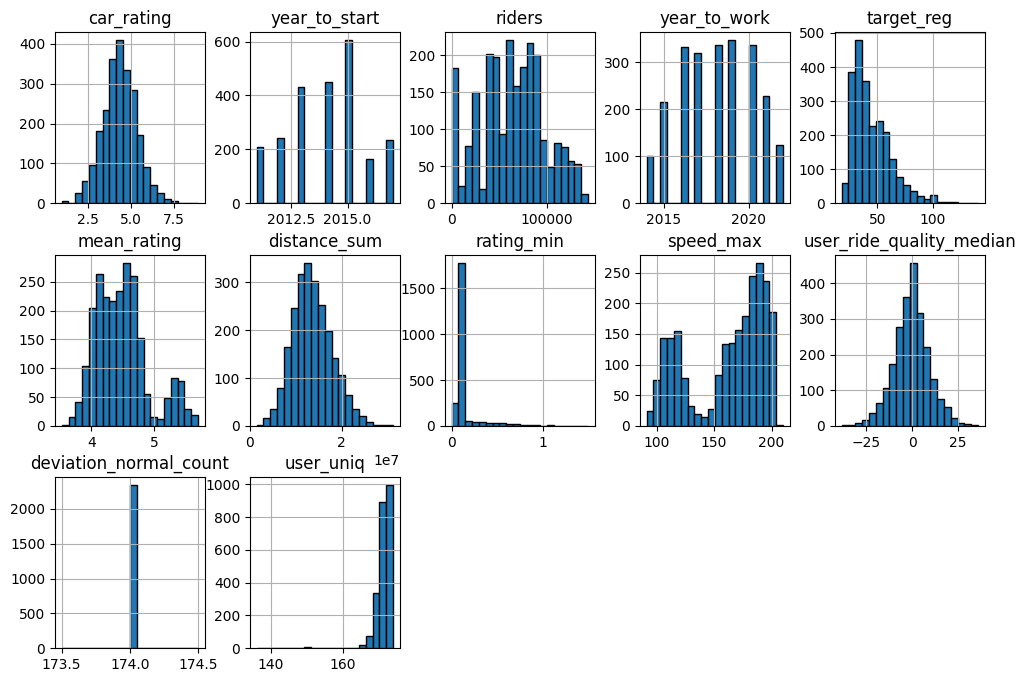

In [23]:
train.hist(figsize=(12,8), layout=(-1,5), bins=20, edgecolor='black')

На гистограммах сразу видно, что признак deviation_normal_count - константный, поэтому не будем его использовать для обучения. Также видно, что числовые признаки придётся стандартизировать для обучения, особенно не бустинговых моделей. Также потребуется стандартизировать и целевую переменную.

In [24]:
# инициализируем листы числовых, категориальных, целевых признаков и признаки, которые не потребуются для анализа.
cat_features = ['model', 'car_type', 'fuel_type']
cat_features_indxs = [0, 1, 2]
targets = [#'target_class',
           'target_reg']
features2drop = ['car_id', 'deviation_normal_count', 'target_class']

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print(f'\033[1mcat_features:\033[0m {cat_features}, \033[1mamount\033[0m = {len(cat_features)}')
print(f'\033[1mnum_features:\033[0m {num_features}, \033[1mamount\033[0m = {len(num_features)}')
print(f'\033[1mtargets:\033[0m {targets}, \033[1mamount\033[0m = {len(targets)}')

cat_features: ['model', 'car_type', 'fuel_type'], amount = 3
num_features: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'user_uniq'], amount = 10
targets: ['target_reg'], amount = 1


In [25]:
# Заменим тип данных object на category в категориальных признаках

for col in cat_features:
    train[col] = train[col].astype("category")

for col in cat_features:
    test[col] = test[col].astype("category")

In [26]:
# инициализируем номер случайного состояния, словарь лучших моделей, словарь для результатов
# датасет для формирования результатов
R_S = 7575
n_est = 400
sampler = optuna.samplers.TPESampler(seed=R_S)

bst_mdls = {}
mean_scores = {}

df_sub = pd.DataFrame(test['car_id'])

In [27]:
# получаем разбиение на фичи и целевую переменную
X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["target_reg"]

# разбиение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=R_S)

# подготовка тестовых данных
X_sub = test[filtered_features].drop(targets, axis=1, errors="ignore")

## Вспомогательные функции и классы

### Класс для нормализации цифровых признаков

Т.к. catboost может работать с категориальными признаками самостоятельно, то будем подавать dataframe в нашу модель. При этом стандартизируем числовые признаки. (пусть для модели catboost, насколько я понимаю, это и не принципиальное действие). Для этого напишем кастомный класс transformer.

In [28]:
class CustomTransformer(TransformerMixin):
    '''
    .. notes::
    Класс трансформации признаков.
    Числовые данные нормализуются или стандартизируются.
    Категориальные признаки не изменяются.
    После трансформаци возвращается датафрейм.
    '''
    def __init__(self,
                 scaler_type: Any=None,
                 cat_feats: list[str]=None,
                 with_mean: bool=True,
                 with_std: bool=True,
                 feature_range: tuple[int, int]=(0, 1)):

        self.scaler_type = scaler_type
        if scaler_type:
            self.scaler = StandardScaler(with_mean=with_mean, with_std=with_std)
        else:
            self.scaler = MinMaxScaler(feature_range=feature_range)

        self.cat_feats = cat_feats

        # print('Init done')
    def fit(self, X: pd.DataFrame, y: pd.Series=None):
        return self

    def transform(self, X: pd.DataFrame, y: pd.Series=None) -> pd.DataFrame:
        X_ = X.copy()
        X_cat = X_[self.cat_feats]
        num_feats = [i for i in X_.columns if i not in self.cat_feats]
        X_num = X_[num_feats]
        X_num = pd.DataFrame(self.scaler.fit_transform(X_num), columns=num_feats)

        res = pd.concat([X_cat.reset_index(), X_num], axis=1)
        return res.set_index('index')

### Класс для нормализации и преобразования для нейронной сети.

Для Tabnet регрессора хотим стандартизировать числовые признаки, при этом категориальные закодировать числами. И на вход tabnet будем подавать массив. Ещё один кастомный класс transformer.

In [29]:
class CustomTransformerNN(TransformerMixin):
    '''
    .. notes::
    Класс трансформации признаков.
    Числовые данные нормализуются или стандартизируются.
    Категориальные признаки кодируютя числами.
    После трансформации получаем.
    '''
    def __init__(self, scaler_type=None, cat_feats=None, with_mean=True, with_std=True, feature_range=(0, 1)):
        self.scaler_type = scaler_type
        if scaler_type:
            self.scaler = StandardScaler(with_mean=with_mean, with_std=with_std,)
        else:
            self.scaler = MinMaxScaler(feature_range=feature_range)

        self.cat_feats = cat_feats

        # print('Init done')
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None) -> np.array:
        X_ = X.copy()
        X_cat = X_[self.cat_feats]
        for col in cat_features:
            X_cat[col] = X_cat[col].replace(np.unique(X_cat[col]), np.arange(X_cat[col].nunique()))
        num_feats = [i for i in X_.columns if i not in self.cat_feats]
        X_num = X_[num_feats]
        X_num = pd.DataFrame(self.scaler.fit_transform(X_num), columns=num_feats)

        res = pd.concat([X_cat.reset_index(), X_num], axis=1)
        return res.set_index('index').values

### Функция для шага обучения

будем использовать scheduler в моделях LGBM и XGB

In [30]:
# функция для шага обучения
def lr_gen_simple(init_lr: float=0.1, epoch: int=400) -> list[float]:
    '''
    :param init_lr: initial number for learning rate
    :type init_lr: float, defaults to 0.1
    :param epoch: amount of epochs
    :type epoch: int, defaults to 400

    :rtype: list[float]

    .. notes:: Функция для формирования листа со значениями шага обучения
    на каждой эпохе.
    -----
    Параметры:
    init_lr - инициализирующий шаг обучения
    epoch - количество эпох

    '''
    decay = init_lr / epoch
    lr_list = [init_lr/(1 + decay * i) for i in range(1, epoch + 1)]

    return lr_list

### Класс для применения моделей.

Соберём класс, в котором будут лежать 2 функции: preparing_features и fit.

preparing_features будет готовить пайплайн для обработки признаков и применения модели. (часть для обработки признаков будет возвраться отдельно). Для catboost и tabnet будем использовать кастомные классы обработки признаков, которые ввели выше. Для остальных моделей: числовые признаки - стандартизируем, категориальные преобразуем при помощи one hot encoding.

fit собственно будет применять нашу модель. Возвращать обученную модель и предсказания.

In [31]:
class FitClass():
    '''
    Класс для применения моделей.
    preparing_features - фунция для создания пайплайнов обработки
    fit - примененение модели
    '''
    @staticmethod
    def preparing_features(name: str, algorithm: Any) -> tuple[Any, Any]:
        '''
        :param name: name of regressor algorithm
        :type name: str
        :param algorithm: class of regressor algorithm
        :type algorithm: Any

        :rtype: tuple[Any, Any]
        :returns: preprocessor pipe for columns and pipe model

        .. notes::
        -----
        Принимает на вход название алгоритма и алгоритм.
        Возвращает цепочку для преобразования фичей,
        цепочку для преобразования фичей и применения модели.
        '''

        if name == 'CatBoostRegressor':
              preprocessor = CustomTransformer(True, cat_feats=cat_features)

              pipe = Pipeline([('feature_preprocessor', preprocessor),
                              ('model', algorithm)])
        elif name == 'TabNetRegressor':
            preprocessor = CustomTransformerNN(True, cat_feats=cat_features)

            pipe = Pipeline([('feature_preprocessor', preprocessor),
                              ('model', algorithm)])
        else:
            numeric_transformer = Pipeline(
                steps=[("imputer", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler())])

            categorical_transformer = Pipeline(
                steps=[("encoder", OneHotEncoder(handle_unknown="ignore")),
                      #  ("selector", SelectPercentile(chi2, percentile=50)),
                      ])
            preprocessor = ColumnTransformer(
                transformers=[("num", numeric_transformer, num_features),
                              ("cat", categorical_transformer, cat_features)])

            pipe = Pipeline([('feature_preprocessor', preprocessor),
                            ('model', algorithm)])

        return preprocessor, pipe

    @staticmethod
    def fit(name: str,
            pipe: Any,
            preprocessor: Any,
            X_train: pd.DataFrame,
            X_val: pd.DataFrame,
            y_train: pd.Series,
            y_val: pd.Series,
            fit_params: dict,
            callbacks=[]):
        '''
        :param name: name of regressor algorithm
        :type name: str
        :param pipe: pipe of preprocessor for features and model
        :type pipe: Any
        :param preprocessor: pipe of preprocessor for features
        :type preprocessor: Any
        :param X_train: train features
        :type X_train: pandas.DataFrame
        :param X_val: validation features
        :type X_val: pandas.DataFrame
        :param y_train: train targer
        :type y_train: pandas.Series
        :param y_val: validation target
        :type y_val: pandas.Series

        :rtype: tuple[np.array, Any]
        :returns: array of predictions, model
        .. notes::
        -----
        Принимает название алгоритма. Применяет алгоритм с заданными параметрами
        к данным.
        Возвращает предсказание. И обученную модель.
        '''
        if name == 'TabNetRegressor':
            target_sc = StandardScaler()
            y_train = target_sc.fit_transform(y_train.values.reshape(-1, 1))
            X_val_eval_NN = X_val.copy()
            eval_set_pipe = Pipeline(steps = [('feature_preprocessor', preprocessor)])
            X_val_eval_NN = eval_set_pipe.fit(X_train).transform(X_val_eval_NN)
            y_val_eval_NN = target_sc.transform(y_val.values.reshape(-1, 1))
        else:
            X_val_eval = X_val.copy()
            eval_set_pipe = Pipeline(steps = [('feature_preprocessor', preprocessor)])
            X_val_eval = eval_set_pipe.fit(X_train).transform(X_val_eval)


        wrapped_model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())

        if name in ['KNeighborsRegressor', 'ElasticNet', 'RandomForestRegressor', 'GaussianProcessRegressor', 'NuSVR', 'MLPRegressor', 'GradientBoostingRegressor']:
            wrapped_model.fit(X_train,
                              y_train,
                              **fit_params
                              )

            y_pred = wrapped_model.predict(X_val)
        elif name == 'TabNetRegressor':
            pipe.fit(X_train, y_train,
                    model__eval_set=[(X_val_eval_NN, y_val_eval_NN)],
                    **fit_params,
                    )
            y_pred = pipe.predict(X_val)
            y_pred = target_sc.inverse_transform(np.array(y_pred).reshape(-1, 1))
            wrapped_model = pipe
        else:
            if callbacks:
                wrapped_model.fit(X_train,
                              y_train,
                              **fit_params,
                              model__callbacks=callbacks,
                              model__eval_set=[(X_val_eval, y_val)],
                              )
                # запускаем процесс прунинга для catboost
                if name == 'CatBoostRegressor':
                    callbacks[-1].check_pruned()
            else:
                wrapped_model.fit(X_train,
                                  y_train,
                                  model__eval_set=[(X_val_eval, y_val)],
                                  **fit_params)

            y_pred = wrapped_model.predict(X_val)

        if name == 'TabNetRegressor':
            return y_pred, wrapped_model, target_sc

        return y_pred, wrapped_model

### Fit algorithm optuna

Объявим функцию обучения для всех моделей. Будем использовать механизм подбора гиперпараметров optuna.

In [32]:
# функция применения алгоритма, когда применяем optuna
def fit_algorithm_optuna(trial: optuna.trial,
                         train: pd.DataFrame,
                         val: pd.DataFrame,
                         algorithm: Any,
                         init_params: dict,
                         grid: dict,
                         fit_params: dict,
                         r_s=R_S,
                         callbacks = []):

    '''
    :param trial: standart optuna parameter
    :type trial: optuna.trial
    :param train: train dataframe
    :type train: pandas.DataFrame
    :param val: validation dataframe
    :type val: pd.DataFrame
    :param algorithm: class of regressor algorithm
    :type algorithm: Any
    :param init_params: initial parameters
    :type init_params: dict
    :param grid: grid of parameters
    :type grid: dict
    :param fit_params: parameters to fit
    :type fit_params: dict
    :param r_s: random state
    :type r_s: int, defaults to 7575
    :param callbacks: callbacks
    :type callbacks: list, defaults to []

    :rtype: tuple[Any, np.array]
    :returns: model, array of predictions
    .. notes::
    -----
    Принимает объект trial из optuna, данные для обучения и валидации, алгоритм, параметры.
    Алгоритм обучается и применяется.
    Возвращает обученную модель и предсказанное значение для валидационной выборки.
    '''

    X_train, y_train = train
    X_val, y_val = val

    # получаем на вход сетку с параметрами для перебора. для пары алгоритмов будем
    # добавлять параметры в сетку, в зависимости от некоторых условий.
    if algorithm.__name__ == 'CatBoostRegressor':
        if grid["bootstrap_type"] == "Bayesian":
            grid["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 20)

        elif grid["bootstrap_type"] == "Bernoulli":
            grid["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    elif algorithm.__name__ == 'XGBRegressor':
        if grid["booster"] == "gbtree" or grid["booster"] == "dart":
            grid["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            grid["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            grid["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            grid["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
            grid["tree_method"]: trial.suggest_categorical("tree_method", ['hist', 'approx'],)
        if grid["booster"] == "dart":
            grid["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            grid["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            grid["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
            grid["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    rgr = algorithm(**init_params, **grid)

    # применяем метод preparing_features - он на вернёт способ обработки данных и общий пайплайн модели
    preprocessor, pipe = FitClass.preparing_features(algorithm.__name__, rgr)
    # для алгоритма TabNet будем возвращать ещё и обученный объект scaler для целевой переменной
    if algorithm.__name__ == 'TabNetRegressor':
        y_pred, wrapped_model, target_sc = FitClass.fit(algorithm.__name__, pipe, preprocessor, X_train, X_val, y_train, y_val, fit_params, callbacks)
        return wrapped_model, y_pred, target_sc

    y_pred, wrapped_model = FitClass.fit(algorithm.__name__, pipe, preprocessor, X_train, X_val, y_train, y_val, fit_params, callbacks)
    # возвращаем модель и прогноз
    return wrapped_model, y_pred

# Модели

## Catboost

In [33]:
# функция для рассчёта метрики в механизме перебора optuna
def objective_catboost(trial: optuna.trial, return_models:bool=False):

    '''
    :param trial: standart optuna parameter
    :type trial: optuna.trial
    :param return_models: parameter to return fitted model or not
    :type return_models: bool, defaults to False

    :type callbacks: list, defaults to []

    :rtype: float | tuple[float, Any]
    :returns: mean value of RMSE on folds, model
    .. notes::
    -----
    Принимает объект trial из optuna и булево значение для возможности возврата модели.

    Разбиваем данные на фолды, и подаём в функцию fit algorithm_optuna на каждом разбиении.

    '''
    # будем использовать pruning
    pruning_callback = CatBoostPruningCallback(trial, "RMSE")
    callbacks = [pruning_callback]

    # параметры, которые не будем перебирать
    init_params = {'loss_function': 'RMSE',
                   'random_seed': R_S,
                   'thread_count': -1,
                   'verbose': 0,
                   'task_type': "CPU",
                   'iterations' : n_est, # Можно не перебирать, есть Early-Stopping,
                   'cat_features': cat_features}
    # сетка с параметрами для перебора
    grid = {'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.01),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 100, 500),
            'l2_leaf_reg': trial.suggest_int("l2_leaf_reg", 2, 50),
            'max_bin': trial.suggest_int('max_bin', 100, 300),
            'boosting_type': trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
            'bootstrap_type': trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
            'depth': trial.suggest_int("depth", 3, 10),
            'colsample_bylevel': trial.suggest_float("colsample_bylevel", 0.01, 0.8),
            # 'subsample': trial.suggest_float("colsample_bylevel", 0.01, 0.95),
            'used_ram_limit': "14gb"}

    # параметры для применения модели. используем early stopping
    fit_params = {'model__cat_features': cat_features,
                  'model__verbose': 0,
                  'model__early_stopping_rounds': 200,
                  'model__plot': False}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)
    # разбиваем на фолды
    scores, models = [], []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Разбиваем на обучающую и валидационную выборки. Подаём данные, параметры и тип алгоритма функцию
        # fit_algorithm_optuna, которая вернёт нам модель и прогноз для валидационных данных

        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             CatBoostRegressor,
                                             init_params,
                                             grid,
                                             fit_params,
                                             callbacks=callbacks)
        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break
    # записываем лучшие модели и результат по фолдам
    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [34]:
%%time
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            #  pruner=optuna.pruners.HyperbandPruner(),
                            direction="minimize", study_name="Catboost_Regressor", sampler=sampler)
study.optimize(objective_catboost,
               n_trials=10,
               n_jobs=-1,
               show_progress_bar=True,)

[I 2023-08-24 15:20:37,627] A new study created in memory with name: Catboost_Regressor


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-08-24 15:20:40,343] Trial 1 finished with value: 16.231816357349754 and parameters: {'learning_rate': 0.005265231540975006, 'min_data_in_leaf': 173, 'l2_leaf_reg': 19, 'max_bin': 106, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'depth': 4, 'colsample_bylevel': 0.073492037990638, 'subsample': 0.4380924033097121}. Best is trial 1 with value: 16.231816357349754.
[I 2023-08-24 15:20:43,607] Trial 0 finished with value: 13.672825320268524 and parameters: {'learning_rate': 0.004320836697114817, 'min_data_in_leaf': 179, 'l2_leaf_reg': 33, 'max_bin': 177, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'depth': 3, 'colsample_bylevel': 0.45501568087030525, 'subsample': 0.9472724538627492}. Best is trial 0 with value: 13.672825320268524.
[I 2023-08-24 15:20:55,581] Trial 2 finished with value: 15.494585027884435 and parameters: {'learning_rate': 0.0034093513146219072, 'min_data_in_leaf': 139, 'l2_leaf_reg': 23, 'max_bin': 171, 'boosting_type': 'Ordered', 'bootst

In [35]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

Best trial: score 12.146289014862225, params {'learning_rate': 0.008214111060164581, 'min_data_in_leaf': 257, 'l2_leaf_reg': 32, 'max_bin': 193, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'depth': 8, 'colsample_bylevel': 0.7651794484885364}


In [36]:
mean_scores['Catboost_score'], bst_mdls['Catboost_model'] = objective_catboost(optuna.trial.FixedTrial(study.best_params), return_models=True)
# mean_scores, bst_mdls

In [37]:
# Сделаем прогноз для тестовых данных
preds = bst_mdls['Catboost_model'].predict(X_sub)
# Добавляем наши предсказания для тестовой выборки в таблицу результатов
df_sub['Catboost_target'] = preds
df_sub.head()

,car_id,Catboost_target
0,P17494612l,46.107975
1,N-1530212S,35.026244
2,B-1154399t,33.471544
3,F12725233R,34.157626
4,l-1139189J,35.073812


## LGBM

In [38]:
def objective_lgbm(trial, return_models=False):

    pruning_callback = LightGBMPruningCallback(trial, "rmse")

    callbacks = [
                 lgb.early_stopping(stopping_rounds=50, verbose=0),
                 lgb.reset_parameter(learning_rate=lr_gen_simple(trial.suggest_float("lr_init", 0.0001, 0.5), n_est)),
                #  pruning_callback
                ]

    init_params = {'metric': "RMSE",
                   'objective': 'regression',
                   'boosting_type': trial.suggest_categorical("boosting_type",
                                                              [ "gbdt",
                                                                "dart"
                                                                ]),
                   'random_seed': R_S,
                   'n_jobs': -1,
                   'verbose': -1,
                   'force_row_wise': True,
                   'num_iterations' : n_est, # Можно не перебирать, есть Early-Stopping
                  #  'cat_features': cat_features,
    }

    grid = {
            #  'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.01),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
            'reg_alpha': trial.suggest_int("reg_alpha", 1e-3, 1),
            'reg_lambda': trial.suggest_int("reg_lambda", 1e-3, 1),
            # 'max_bin': trial.suggest_int('max_bin', 100, 300),
            'num_leaves': trial.suggest_int('num_leaves', 2, 6),
            'colsample_bytree': trial.suggest_float("colsample_bytree", 0.01, 0.95),
            'subsample': trial.suggest_float("subsample", 0.5, 1),
        }

    fit_params = { }

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      LGBMRegressor,
                                      init_params,
                                      grid,
                                      fit_params,
                                      callbacks=callbacks)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    # print('scores', scores)
    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [39]:
%%time
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            direction="minimize", study_name="LGBM_Regressor", sampler=sampler)
study.optimize(objective_lgbm,
               n_trials=10,
               n_jobs=-1,
               show_progress_bar=True,)

[I 2023-08-24 15:22:26,906] A new study created in memory with name: LGBM_Regressor


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-08-24 15:22:28,650] Trial 0 finished with value: 12.073166290552031 and parameters: {'lr_init': 0.2518917951046577, 'boosting_type': 'gbdt', 'min_child_samples': 42, 'reg_alpha': 1, 'reg_lambda': 0, 'num_leaves': 3, 'colsample_bytree': 0.6768931189344036, 'subsample': 0.735792896403357}. Best is trial 0 with value: 12.073166290552031.
[I 2023-08-24 15:22:29,090] Trial 1 finished with value: 12.472578076032143 and parameters: {'lr_init': 0.30686404059919153, 'boosting_type': 'dart', 'min_child_samples': 61, 'reg_alpha': 0, 'reg_lambda': 1, 'num_leaves': 4, 'colsample_bytree': 0.2068159822476258, 'subsample': 0.6890861350862807}. Best is trial 0 with value: 12.073166290552031.
[I 2023-08-24 15:22:29,910] Trial 3 finished with value: 16.377454108345926 and parameters: {'lr_init': 0.00660029357106376, 'boosting_type': 'dart', 'min_child_samples': 79, 'reg_alpha': 0, 'reg_lambda': 1, 'num_leaves': 2, 'colsample_bytree': 0.10169915107621594, 'subsample': 0.7200048543839856}. Best is 

In [40]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['LGBM_score'], bst_mdls['LGBM_model'] = objective_lgbm(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 12.073166290552031, params {'lr_init': 0.2518917951046577, 'boosting_type': 'gbdt', 'min_child_samples': 42, 'reg_alpha': 1, 'reg_lambda': 0, 'num_leaves': 3, 'colsample_bytree': 0.6768931189344036, 'subsample': 0.735792896403357}
[LightGBM] [Info] Start training from score -0.000030
[LightGBM] [Info] Start training from score -0.000002
[LightGBM] [Info] Start training from score -0.000034


In [41]:
preds = bst_mdls['LGBM_model'].predict(X_sub)

df_sub['LGBM_target'] = preds
# df_sub.head()

## TabNet

In [42]:
def objective_tabnet(trial, return_models=False):

    # pruning_callback = pytorch_tabnet.callbacks.LRSchedulerCallback()
    # callbacks = [pruning_callback]

    init_params = {'device_name':'cpu',
                   'cat_idxs': cat_features_indxs,
                   'cat_dims': [26, 4, 2],
                   'verbose': 0,
                  #  'verbose_eval': 0,
                   'seed': R_S,
                   'optimizer_fn': torch.optim.Adam,
                   'optimizer_params': dict(lr=2e-2, weight_decay=1e-5),
                   'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
    }

    grid = {
             'mask_type': trial.suggest_categorical("mask_type", ["entmax", "sparsemax"]),
             'n_d': trial.suggest_int("n_d", 2, 20, step=4),
             'n_a': trial.suggest_int("n_a", 2, 20, step=4),
             'n_steps': trial.suggest_int("n_steps", 1, 3, step=1),
             'gamma': trial.suggest_float("gamma", 1., 1.4, step=0.2),
             'cat_emb_dim': trial.suggest_int("cat_emb_dim", 1, 10, step=2),
             'n_independent': trial.suggest_int("n_independent", 1, 3),
             'n_shared': trial.suggest_int("n_shared", 1, 3),
             'momentum': trial.suggest_float("momentum", .01, .4, step=0.2),
             'lambda_sparse': trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True),
             'scheduler_params': dict(mode="min",
                                      patience=trial.suggest_int("patienceScheduler", low=3, high=10), # changing sheduler patience to be lower than early stopping patience
                                      min_lr=1e-5,
                                      factor=0.5,
                                      # verbose=-1
                                      )
    }

    fit_params = {#'model__verbose': 0,
                  # 'model__eval_verbose': 0,
                  'model__eval_metric':['rmse'],
                  'model__patience': trial.suggest_int("model_patience", low=15, high=30),
                  'model__max_epochs': 100
                  }

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models ,scs = [], [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred, target_sc = fit_algorithm_optuna(trial,
                                                        train_data,
                                                        valid_data,
                                                        TabNetRegressor,
                                                        init_params,
                                                        grid,
                                                        fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        scs.append(target_sc)
        models.append(model)
        break

    # print('scores', scores)
    bst_mdl = models[np.argmin(scores)]
    bst_ts = scs[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl, bst_ts
    else:
        return result

In [43]:
%%time
optuna.logging.set_verbosity(optuna.logging.WARNING)
# optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(#pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            direction="minimize", study_name="TabNet_Regressor", sampler=sampler)
study.optimize(objective_tabnet,
               n_trials=20,
               n_jobs=-1,
               show_progress_bar=True, #timeout=60
               )

  0%|          | 0/20 [00:00<?, ?it/s]


Early stopping occurred at epoch 61 with best_epoch = 43 and best_val_0_rmse = 0.8128600120544434

Early stopping occurred at epoch 79 with best_epoch = 54 and best_val_0_rmse = 0.8183900117874146

Early stopping occurred at epoch 70 with best_epoch = 54 and best_val_0_rmse = 0.7638800144195557

Early stopping occurred at epoch 55 with best_epoch = 37 and best_val_0_rmse = 0.8154199719429016

Early stopping occurred at epoch 95 with best_epoch = 72 and best_val_0_rmse = 0.7247800230979919

Early stopping occurred at epoch 65 with best_epoch = 39 and best_val_0_rmse = 0.7143099904060364
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_rmse = 0.7808099985122681
Stop training because you reached max_epochs = 100 with best_epoch = 97 and best_val_0_rmse = 0.813319981098175

Early stopping occurred at epoch 68 with best_epoch = 44 and best_val_0_rmse = 0.7775899767875671

Early stopping occurred at epoch 93 with best_epoch = 70 and best_val_0_rmse = 0.

In [44]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['TabNet_score'], bst_mdls['TabNet_model'], target_sc = objective_tabnet(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 12.438241958618164, params {'mask_type': 'entmax', 'n_d': 14, 'n_a': 14, 'n_steps': 2, 'gamma': 1.4, 'cat_emb_dim': 7, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.21, 'lambda_sparse': 8.155773934581139e-05, 'patienceScheduler': 3, 'model_patience': 26}
Stop training because you reached max_epochs = 100 with best_epoch = 85 and best_val_0_rmse = 0.7260800004005432


In [45]:
preds = bst_mdls['TabNet_model'].predict(X_sub)
preds = target_sc.inverse_transform(np.array(preds).reshape(-1, 1))

df_sub['TabNet_target'] = preds
# df_sub.head()

## KNN regressor

In [46]:
def objective_knn(trial, return_models=False):
    init_params = { 'n_jobs': -1 }

    grid = {
             'weights': trial.suggest_categorical("weights", ['uniform', 'distance'],),
             'n_neighbors': trial.suggest_int("n_neighbors", 150, 250, step=4),
             'leaf_size': trial.suggest_int("leaf_size", 150, 250, step=4),
             'p':  trial.suggest_int("p", 1, 2)
             }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             KNeighborsRegressor,
                                             init_params,
                                             grid,
                                             fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [47]:
%%time
# optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize", study_name="KNN_Regressor", sampler=sampler)
study.optimize(objective_knn,
               n_trials=5,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 3.74 s, sys: 63.2 ms, total: 3.8 s
Wall time: 3.04 s


In [48]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['KNN_score'], bst_mdls['KNN_model'] = objective_knn(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 15.475667439464557, params {'weights': 'distance', 'n_neighbors': 214, 'leaf_size': 158, 'p': 1}


In [49]:
preds = bst_mdls['KNN_model'].predict(X_sub)

df_sub['KNN_target'] = preds
# df_sub.head()

## Elastic net regressor

In [50]:
def objective_elastik(trial, return_models=False):
    init_params = {'random_state': R_S,}

    grid = {'max_iter': trial.suggest_int("max_iter", 500, 1000, step=4),
             'l1_ratio': trial.suggest_float("l1_ratio", 0.001, 1),
             'alpha':  trial.suggest_float("alpha", 0.001, 1)}

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]


        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             ElasticNet,
                                             init_params,
                                             grid,
                                             fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [51]:
%%time
study = optuna.create_study(direction="minimize", study_name="Elastik_Regressor", sampler=sampler)
study.optimize(objective_elastik,
               n_trials=100,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 19.1 s, sys: 940 ms, total: 20.1 s
Wall time: 18.9 s


In [52]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['Elastic_score'], bst_mdls['Elastic_model'] = objective_elastik(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 14.548798511452809, params {'max_iter': 668, 'l1_ratio': 0.008304247435315881, 'alpha': 0.012752926830600586}


In [53]:
preds = bst_mdls['Elastic_model'].predict(X_sub)

df_sub['Elastic_target'] = preds
# df_sub.head()

## GradientBoosting regressor

In [54]:
def objective_gradient_boosting(trial, return_models=False):
    init_params = {'random_state': R_S,
                  #  'n_jobs': -1,
                   }

    grid = { #'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.01),
             'n_estimators': trial.suggest_int("n_estimators", 200, 400, step=4),
             'subsample': trial.suggest_float("colsample_bylevel", 0.01, 0.95),
             'criterion': trial.suggest_categorical("criterion", ["friedman_mse", "squared_error"]),
             'min_samples_split': trial.suggest_int("min_samples_split", 2, 400),
             'min_samples_leaf': trial.suggest_int("min_samples_leaf", 2, 400),
             'max_depth': trial.suggest_int("max_depth", 2, 10),
             'n_iter_no_change': trial.suggest_int("n_iter_no_change", 2, 100),
             }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]


        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      GradientBoostingRegressor,
                                      init_params,
                                      grid,
                                      fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [55]:
%%time
# optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize", study_name="GB_Regressor", sampler=sampler)
study.optimize(objective_gradient_boosting,
               n_trials=5,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 6.23 s, sys: 196 ms, total: 6.43 s
Wall time: 4.42 s


In [56]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['GB_score'], bst_mdls['GB_model'] = objective_gradient_boosting(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 13.20517331739029, params {'n_estimators': 212, 'colsample_bylevel': 0.6094981461180072, 'criterion': 'friedman_mse', 'min_samples_split': 85, 'min_samples_leaf': 120, 'max_depth': 10, 'n_iter_no_change': 76}


In [57]:
bst_mdls['GB_model']

TransformedTargetRegressor(regressor=Pipeline(steps=[('feature_preprocessor',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(strategy='median')),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['car_rating',
                                                                                        'year_to_start',
                                                                                        'riders',
                                                                                        'year_to_work',
                                                                                        'mean_rating',
                                                                                        'distance_sum',
                                                                                        'rating_min',
                                                                                        'speed_max',
                                                                                        'user_ride_quality_median',
                                                                                        'user_uniq']),
                                                                                      ('cat',
                                                                                       Pipeline(steps=[('encoder',
                                                                                                        OneHotEncoder(handle_unknown='ignore'))]),
                                                                                       ['model',
                                                                                        'car_type',
                                                                                        'fuel_type'])])),
                                                     ('model',
                                                      GradientBoostingRegressor(max_depth=10,
                                                                                min_samples_leaf=120,
                                                                                min_samples_split=85,
                                                                                n_estimators=212,
                                                                                n_iter_no_change=76,
                                                                                random_state=7575,
                                                                                subsample=0.6094981461180072))]),
                           transformer=StandardScaler())

In [58]:
preds = bst_mdls['GB_model'].predict(X_sub)

df_sub['GB_target'] = preds
df_sub.head()

,car_id,Catboost_target,LGBM_target,TabNet_target,KNN_target,Elastic_target,GB_target
0,P17494612l,46.107975,51.864481,43.624146,45.928378,48.580390,55.434629
1,N-1530212S,35.026244,35.802667,35.076065,45.428087,46.870772,45.068710
2,B-1154399t,33.471544,33.240155,27.971327,38.773677,39.134141,28.983985
3,F12725233R,34.157626,37.159862,36.173214,41.544559,42.636301,34.673433
4,l-1139189J,35.073812,29.306731,33.222065,45.769868,50.478241,47.338305


## Random Forrest regressor

In [59]:
def objective_random_forest(trial, return_models=False):
    init_params = {'random_state': R_S,
                   'n_jobs': -1}

    grid = { 'n_estimators': trial.suggest_int("n_estimators", 200, 500, step=4),
             'max_depth': trial.suggest_int("max_depth", 2, 10),
             'max_samples': trial.suggest_int("max_samples", 100, 300),
            #  'min_samples_leaf': trial.suggest_int("min_samples_leaf", 50, 150),
             }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      RandomForestRegressor,
                                      init_params,
                                      grid,
                                      fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [60]:
%%time
# optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize", study_name="Random_Forest_Regressor", sampler=sampler)
study.optimize(objective_random_forest,
               n_trials=50,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 3min 40s, sys: 11.1 s, total: 3min 51s
Wall time: 3min 17s


In [61]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['RF_score'], bst_mdls['RF_model'] = objective_random_forest(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 11.7555853705682, params {'n_estimators': 268, 'max_depth': 9, 'max_samples': 289}


In [62]:
preds = bst_mdls['RF_model'].predict(X_sub)

df_sub['RF_target'] = preds
df_sub.head()

,car_id,Catboost_target,LGBM_target,TabNet_target,KNN_target,Elastic_target,GB_target,RF_target
0,P17494612l,46.107975,51.864481,43.624146,45.928378,48.580390,55.434629,43.085989
1,N-1530212S,35.026244,35.802667,35.076065,45.428087,46.870772,45.068710,33.300287
2,B-1154399t,33.471544,33.240155,27.971327,38.773677,39.134141,28.983985,32.184286
3,F12725233R,34.157626,37.159862,36.173214,41.544559,42.636301,34.673433,35.159052
4,l-1139189J,35.073812,29.306731,33.222065,45.769868,50.478241,47.338305,32.586216


## Gaussian Process regressor

In [63]:
def objective_gaussian(trial, return_models=False):
    init_params = {'random_state': R_S,}

    grid = {
            'alpha': trial.suggest_float("alpha", 0.2, 1),
           }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]


        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      GaussianProcessRegressor,
                                      init_params,
                                      grid,
                                      fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_pred, y_true, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [64]:
%%time
# optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize", study_name="Gaussian_Regressor")
study.optimize(objective_gaussian,
               n_trials=100,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 3min 3s, sys: 13.9 s, total: 3min 17s
Wall time: 2min 41s


In [65]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['Gauss_score'], bst_mdls['Gauss_model'] = objective_gaussian(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 14.911442572779677, params {'alpha': 0.200119549667588}


In [66]:
preds = bst_mdls['Gauss_model'].predict(X_sub)

df_sub['Gauss_target'] = preds
df_sub.head()

,car_id,Catboost_target,LGBM_target,TabNet_target,KNN_target,Elastic_target,GB_target,RF_target,Gauss_target
0,P17494612l,46.107975,51.864481,43.624146,45.928378,48.580390,55.434629,43.085989,41.884543
1,N-1530212S,35.026244,35.802667,35.076065,45.428087,46.870772,45.068710,33.300287,43.470288
2,B-1154399t,33.471544,33.240155,27.971327,38.773677,39.134141,28.983985,32.184286,37.710633
3,F12725233R,34.157626,37.159862,36.173214,41.544559,42.636301,34.673433,35.159052,45.404788
4,l-1139189J,35.073812,29.306731,33.222065,45.769868,50.478241,47.338305,32.586216,44.868693


## SVM regressor

In [67]:
def objective_svm(trial, return_models=False):
    init_params = {}

    grid = {
            'max_iter': trial.suggest_int('max_iter', 50, 500),
            'C': trial.suggest_float("C", 0.2, 1),
           }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]


        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      NuSVR,
                                      init_params,
                                      grid,
                                      fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [68]:
%%time
# optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize", study_name="SVM_Regressor", sampler=sampler)
study.optimize(objective_svm,
               n_trials=100,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 1min 36s, sys: 398 ms, total: 1min 36s
Wall time: 1min 22s


In [69]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['SVM_score'], bst_mdls['SVM_model'] = objective_svm(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 12.84411163222473, params {'max_iter': 470, 'C': 0.8592090859486119}


In [70]:
preds = bst_mdls['SVM_model'].predict(X_sub)

df_sub['SVM_target'] = preds
df_sub.head()

,car_id,Catboost_target,LGBM_target,TabNet_target,KNN_target,Elastic_target,GB_target,RF_target,Gauss_target,SVM_target
0,P17494612l,46.107975,51.864481,43.624146,45.928378,48.580390,55.434629,43.085989,41.884543,36.484231
1,N-1530212S,35.026244,35.802667,35.076065,45.428087,46.870772,45.068710,33.300287,43.470288,38.075688
2,B-1154399t,33.471544,33.240155,27.971327,38.773677,39.134141,28.983985,32.184286,37.710633,31.683309
3,F12725233R,34.157626,37.159862,36.173214,41.544559,42.636301,34.673433,35.159052,45.404788,44.674957
4,l-1139189J,35.073812,29.306731,33.222065,45.769868,50.478241,47.338305,32.586216,44.868693,42.295330


## MLP regressor

In [71]:
def objective_mlp(trial, return_models=False):
    init_params = {'random_state': R_S}

    grid = {'hidden_layer_sizes': trial.suggest_int('hidden_layer_sizes', 50, 200),
            'alpha': trial.suggest_int('alpha', 50, 500),
            'batch_size': trial.suggest_int('batch_size', 50, 200),
            'n_iter_no_change': trial.suggest_int('n_iter_no_change', 10, 50),
            'max_iter': trial.suggest_int('max_iter', 10, 500),
            'learning_rate': trial.suggest_categorical("learning_rate", ['constant', 'invscaling', 'adaptive'],),
            'beta_1': trial.suggest_float("beta_1", 0.5, 1),
            'beta_2': trial.suggest_float("beta_2", 0.5, 0.9),
           }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]


        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             MLPRegressor,
                                             init_params,
                                             grid,
                                             fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [72]:
%%time
# optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize", study_name="MLP_Regressor", sampler=sampler)
study.optimize(objective_mlp,
               n_trials=5,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 27.9 s, sys: 1.46 s, total: 29.4 s
Wall time: 28 s


In [73]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['MLP_score'], bst_mdls['MLP_model'] = objective_mlp(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 17.661456399410124, params {'hidden_layer_sizes': 175, 'alpha': 444, 'batch_size': 90, 'n_iter_no_change': 45, 'max_iter': 277, 'learning_rate': 'invscaling', 'beta_1': 0.9680399473593652, 'beta_2': 0.6611155812422779}


In [74]:
preds = bst_mdls['MLP_model'].predict(X_sub)

df_sub['MLP_target'] = preds
df_sub.head()

,car_id,Catboost_target,LGBM_target,TabNet_target,KNN_target,Elastic_target,GB_target,RF_target,Gauss_target,SVM_target,MLP_target
0,P17494612l,46.107975,51.864481,43.624146,45.928378,48.580390,55.434629,43.085989,41.884543,36.484231,45.274860
1,N-1530212S,35.026244,35.802667,35.076065,45.428087,46.870772,45.068710,33.300287,43.470288,38.075688,45.282402
2,B-1154399t,33.471544,33.240155,27.971327,38.773677,39.134141,28.983985,32.184286,37.710633,31.683309,45.284579
3,F12725233R,34.157626,37.159862,36.173214,41.544559,42.636301,34.673433,35.159052,45.404788,44.674957,45.279146
4,l-1139189J,35.073812,29.306731,33.222065,45.769868,50.478241,47.338305,32.586216,44.868693,42.295330,45.275927


## XGBoost

In [75]:
def objective_xgb(trial, return_models=False):

    pruning_callback = XGBoostPruningCallback(trial, 'validation_0-rmse')

    callbacks = [xgb.callback.LearningRateScheduler(lr_gen_simple(trial.suggest_float("lr_init", 0.0001, 0.5), trial.suggest_int('n_rounds', 20, 350))),
                #  xgb.callback.EarlyStopping(rounds=trial.suggest_int("early_stopping_rounds", 1000, 1500), metric_name="RMSE"),
                 pruning_callback]


    init_params = {'eval_metric':'rmse',
                   'random_state': R_S,
                   'n_jobs':-1,
                   'n_estimators': trial.suggest_int('n_rounds', 50, 300),
                   'objective': 'reg:squarederror',
                   }

    grid = {
            #  'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.01),
            "booster": trial.suggest_categorical("booster", ["gbtree",
                                                            #  "gblinear",
                                                             "dart"
                                                             ]),
            # 'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_leaves': trial.suggest_int('max_leaves', 2, 10),
            'lambda': trial.suggest_int("lambda", 2, 50),
            'max_bin': trial.suggest_int('max_bin', 50, 300),
            'alpha': trial.suggest_int('alpha', 2, 50),
            'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 0.95),
            'subsample': trial.suggest_float("subsample", 0.5, 0.95),
            'min_child_weight': trial.suggest_float("min_child_weight", 1, 10),
        }


    fit_params = {'model__verbose': 0,
                  # 'model__early_stopping_rounds': 20
                  }

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]


        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      XGBRegressor,
                                      init_params,
                                      grid,
                                      fit_params,
                                      callbacks=callbacks)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [76]:
%%time
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            direction="minimize", study_name="XGB_Regressor", sampler=sampler)
study.optimize(objective_xgb,
               n_trials=10,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 44.5 s, sys: 2.1 s, total: 46.6 s
Wall time: 39.4 s


In [77]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['XGB_score'], bst_mdls['XGB_model'] = objective_xgb(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 11.850239753723145, params {'lr_init': 0.49343543419231967, 'n_rounds': 281, 'booster': 'gbtree', 'max_leaves': 9, 'lambda': 16, 'max_bin': 252, 'alpha': 20, 'colsample_bytree': 0.5115111055197535, 'subsample': 0.9188512904995899, 'min_child_weight': 1.9874318941815317, 'max_depth': 4, 'eta': 1.8388021093974425e-07, 'gamma': 4.3222181058836876e-05, 'grow_policy': 'depthwise'}


In [78]:
preds = bst_mdls['XGB_model'].predict(X_sub)

df_sub['XGB_target'] = preds
df_sub.head()

,car_id,Catboost_target,LGBM_target,TabNet_target,KNN_target,Elastic_target,GB_target,RF_target,Gauss_target,SVM_target,MLP_target,XGB_target
0,P17494612l,46.107975,51.864481,43.624146,45.928378,48.580390,55.434629,43.085989,41.884543,36.484231,45.274860,54.725468
1,N-1530212S,35.026244,35.802667,35.076065,45.428087,46.870772,45.068710,33.300287,43.470288,38.075688,45.282402,35.243450
2,B-1154399t,33.471544,33.240155,27.971327,38.773677,39.134141,28.983985,32.184286,37.710633,31.683309,45.284579,29.797121
3,F12725233R,34.157626,37.159862,36.173214,41.544559,42.636301,34.673433,35.159052,45.404788,44.674957,45.279146,37.474152
4,l-1139189J,35.073812,29.306731,33.222065,45.769868,50.478241,47.338305,32.586216,44.868693,42.295330,45.275927,32.838558


# Блендинг

In [79]:
# gs = RandomForestRegressor()
# numeric_transformer = Pipeline(
#                 steps=[("imputer", SimpleImputer(strategy="median")),
#                       ("scaler", StandardScaler())])

# categorical_transformer = Pipeline(
#                 steps=[("encoder", OneHotEncoder(handle_unknown="ignore")),
#                       #  ("selector", SelectPercentile(chi2, percentile=50)),
#                       ])
# preprocessor = ColumnTransformer(
#                 transformers=[("num", numeric_transformer, num_features),
#                               ("cat", categorical_transformer, cat_features)])

# pipe = Pipeline([('feature_preprocessor', preprocessor),
#                             ('model', gs)])
# pipe.fit(X_train, y_train)

In [80]:
mean_scores = {k: v for k, v in sorted(mean_scores.items(), key=lambda item: item[1])}
mean_scores

{'RF_score': 11.7555853705682,
 'XGB_score': 11.85024,
 'LGBM_score': 12.073166290552031,
 'Catboost_score': 12.146289014862225,
 'TabNet_score': 12.643242,
 'SVM_score': 12.84411163222473,
 'GB_score': 13.20517331739029,
 'Elastic_score': 14.548798511452809,
 'Gauss_score': 14.911442572779677,
 'KNN_score': 15.475667439464557,
 'MLP_score': 17.661456399410124}

In [81]:
# разбиение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [82]:
df_val = pd.DataFrame()
df_val['target_val'] = y_val.values
scores = {}
TabNet_model = bst_mdls.pop('TabNet_model')
for el in bst_mdls:
   y_pred = bst_mdls[el].predict(X_val)
   df_val[el] = y_pred
   scores[el] = mean_squared_error(y_true=y_val, y_pred=y_pred, squared=False)

target_sc = StandardScaler()
target_sc.fit(y_train.values.reshape(-1, 1))
# y_val_ = target_sc.fit_transform(y_val.values.reshape(-1, 1))
preds = TabNet_model.predict(X_val)
y_pred = target_sc.inverse_transform(np.array(preds).reshape(-1,1))
scores['TabNetmodel'] = mean_squared_error(y_true=y_val, y_pred=y_pred, squared=False)
bst_mdls['TabNet_model'] = TabNet_model
# scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1])}
# scores

In [83]:
df_val.head()

,target_val,Catboost_model,LGBM_model,KNN_model,Elastic_model,GB_model,RF_model,Gauss_model,SVM_model,MLP_model,XGB_model
0,35.531250,48.496534,45.389972,35.532687,45.145110,43.540871,46.851150,42.165403,44.420337,45.283427,43.779411
1,29.343750,34.178769,31.567028,29.341756,44.687709,40.030422,32.140228,31.278960,36.899133,45.280969,29.437584
2,41.375000,33.186000,30.933201,41.376034,35.826738,35.103728,33.833808,40.514392,30.569944,45.284476,31.869175
3,26.703125,35.932891,30.261486,41.664908,30.504729,32.491087,33.793941,38.855369,35.427699,45.285872,30.726276
4,33.281250,46.304785,46.129089,45.635635,44.550816,38.928796,47.698591,53.774961,45.447377,45.281337,47.378120


<Axes: >

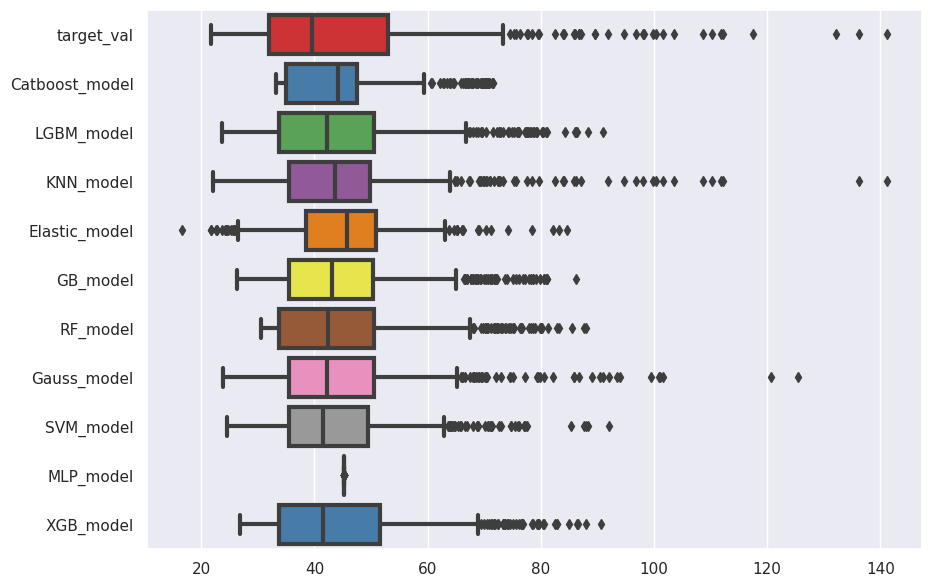

In [84]:
sns.set(rc={"figure.figsize":(10, 7)})
sns.boxplot(data=df_val,whis=1,linewidth=3,orient="h",palette="Set1")

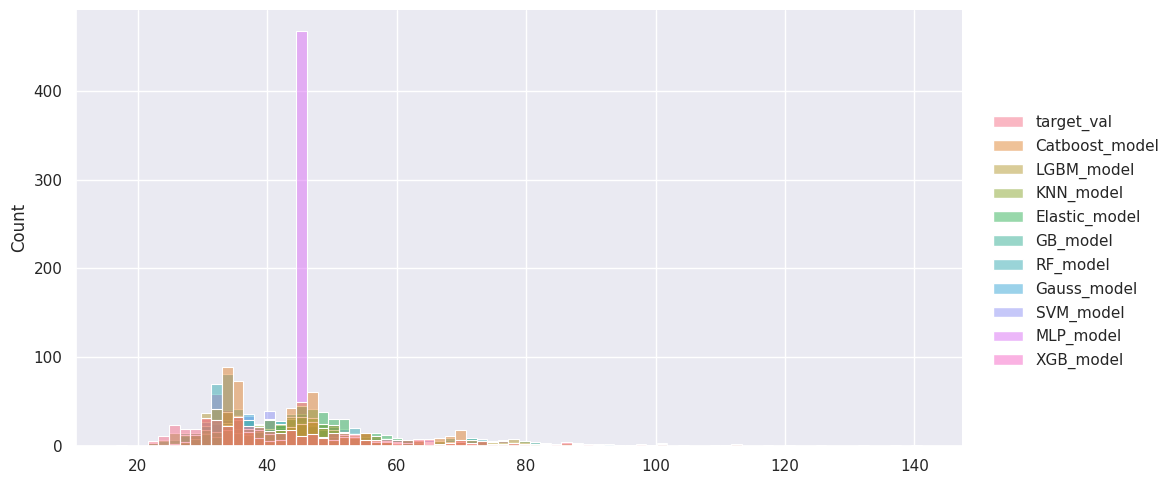

In [85]:
sns.displot(df_val, kind="hist", aspect=2)

По распределению можно предположить, что простые модели, например, KNN и Gauss очень хорошо предсказывают валидационную выборку. Но они у меня просто переобучались при подборе параметров на optuna, поэтому будем ориентироваться на показатели RMSE по кросс-валидации.

Но видно, что модели Catboost и LGBM достаточно плохо предсказывают экстремальные значения таргета. Вероятно этих значений не так много и модели не очень хорошо на них обучаются. Попытаемся скомпенсировать это добавив к нашим бустингам линейную модель. Для блендинга нам требуется взять 2 бустинга и одну модель не бустинг. Возьмём в наш набор для блендинга Catboost, LGBM и KNN.

In [138]:
df_sub_blending = df_sub[['car_id',
                          'Catboost_target',
                          'LGBM_target',
                          'KNN_target',]]
df_sub_blending.head()

,car_id,Catboost_target,LGBM_target,KNN_target
0,P17494612l,46.107975,51.864481,45.928378
1,N-1530212S,35.026244,35.802667,45.428087
2,B-1154399t,33.471544,33.240155,38.773677
3,F12725233R,34.157626,37.159862,41.544559
4,l-1139189J,35.073812,29.306731,45.769868


In [139]:
scores_mdls_chosen = {}
for i in range(len(df_sub_blending.columns)):
    _ = re.sub(r'_target', '_score', df_sub_blending.columns[i])
    if _ in mean_scores:
        scores_mdls_chosen.update({_: mean_scores[_]})

scores_mdls_chosen

{'Catboost_score': 12.146289014862225,
 'LGBM_score': 12.073166290552031,
 'KNN_score': 15.475667439464557}

Можем высчитаем коэффициенты для блендинга автоматически, пропрорционально усреднённым метрикам. Но мне это давало результат хуже, чем выставление вручную. Поэтому оставил выставление вручную.

In [140]:
# высчитаем веса для результатов модели пропорционально метрике RMSE
# scores = 1 / np.array(list(scores_mdls_chosen.values()))
# all_sum = np.sum(scores)
# weights_ = scores / all_sum
# # weights_

# weights = {}
# for f, b in zip(scores_mdls_chosen, weights_):
#     weights.update({f: b})
# print(weights)

# # домножим наши веса на колонки и сложим значения
# def forward(row):
#     average = 0
#     for el in scores_mdls_chosen:
#        _ = re.sub(r'_score', '_target', el)
#        average += row[_] * weights[el]

#     return average

# df_sub_blending['target_reg'] = df_sub.apply(forward, axis=1)

# код для ручного выставления весов
weights = [.4, .4, .2]
def forward(row):
    average = 0
    for i, el in enumerate(scores_mdls_chosen):
        _ = re.sub(r'_score', '_target', el)
        average += row[_] * weights[i]

    return average

df_sub_blending['target_reg'] = df_sub_blending.apply(forward, axis=1)
df_sub_blending.head()

,car_id,Catboost_target,LGBM_target,KNN_target,target_reg
0,P17494612l,46.107975,51.864481,45.928378,48.374658
1,N-1530212S,35.026244,35.802667,45.428087,37.417181
2,B-1154399t,33.471544,33.240155,38.773677,34.439415
3,F12725233R,34.157626,37.159862,41.544559,36.835907
4,l-1139189J,35.073812,29.306731,45.769868,34.906191


In [141]:
# получаем предсказания от блендинга
df_sub_blending = df_sub_blending[['car_id', 'target_reg']]
df_sub_blending.to_csv('result_1.csv', index=False)

# Стекинг

## Pystacknet

In [175]:
ctbrgr = CatBoostRegressor(subsample=0.95,
                                    min_data_in_leaf=350,
                                    max_bin=290,
                                    learning_rate=0.06,
                                    l2_leaf_reg=2,
                                    depth=7,
                          #  cat_features=cat_features
                           )
# lgbmrgr = LGBMRegressor(subsample=0.95,
#                         num_leaves=9,
#                         min_data_in_leaf=8,
#                         max_depth=11,
#                         max_bin=60,
#                         lambda_l2=2,
#                         colsample_bytree=0.9
#     )
rfrgr = RandomForestRegressor(n_estimators=512,
                              max_depth=5,
                              max_features='sqrt',
                              random_state=R_S)

preprocessor, rfpipe = FitClass.preparing_features(RandomForestRegressor, rfrgr)

In [174]:
# ctbrgr = bst_mdls['Catboost_model']
# lgbmrgr = bst_mdls['LGBM_model']

In [176]:
# models = [[ctbrgr, lgbmrgr], # Level 1
#            [rfrgr]
#           [pipe]
#           ] # Level 2
models = [[ctbrgr], # Level 1
          [ctbrgr]
          ] # Level 2

In [134]:
!git clone https://github.com/nedokormysh/my_pystacknet_corrected
# print(os.listdir("kaggle_pystacknet/pystacknet"))
# !pip install "/content/my_pystacknet_corrected/pystacknet"
!pip install "/content/my_pystacknet_corrected/pystacknet" -q
# import pystacknet

Cloning into 'my_pystacknet_corrected'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 56 (delta 12), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (56/56), 1012.92 KiB | 8.04 MiB/s, done.
Resolving deltas: 100% (12/12), done.
  Preparing metadata (setup.py) ... done


In [147]:
import joblib
import sys

sys.modules['sklearn.externals.joblib'] = joblib

from pystacknet.pystacknet import StackNetRegressor

In [177]:
# Specify parameters for stacked model and begin training
model = StackNetRegressor(models,
                          metric="rmse",
                          folds=4,
                          restacking=False,
                          use_retraining=True,
                          #  use_proba=True, # To use predict_proba after training
                          random_state=0,
                          #  n_jobs=-1,
                          verbose=1)

# Fit the entire model tree
# del models
model

StackNetRegressor(folds=4, metric=<function rmse at 0x7f815973f6d0>,
                  models=[[<catboost.core.CatBoostRegressor object at 0x7f8169d5d600>],
                          [<catboost.core.CatBoostRegressor object at 0x7f8169d5d600>]],
                  random_state=0, verbose=1)

In [178]:
X_train=X_train.drop(['model', 'car_type', 'fuel_type'], axis=1)
X_train

KeyError: ignored

In [179]:
model.fit(X_train, y_train)

Выходные данные были обрезаны до нескольких последних строк (5000).
13:	learn: 13.3060562	total: 19.6ms	remaining: 1.38s
14:	learn: 13.1700321	total: 20.9ms	remaining: 1.37s
15:	learn: 13.0576953	total: 22.3ms	remaining: 1.37s
16:	learn: 12.9450500	total: 23.6ms	remaining: 1.36s
17:	learn: 12.8460944	total: 25ms	remaining: 1.36s
18:	learn: 12.7559883	total: 26.3ms	remaining: 1.36s
19:	learn: 12.6749007	total: 28ms	remaining: 1.37s
20:	learn: 12.6032108	total: 29.5ms	remaining: 1.38s
21:	learn: 12.5333424	total: 31ms	remaining: 1.38s
22:	learn: 12.4774410	total: 32.5ms	remaining: 1.38s
23:	learn: 12.4207063	total: 33.9ms	remaining: 1.38s
24:	learn: 12.3714687	total: 35.3ms	remaining: 1.38s
25:	learn: 12.3312375	total: 36.8ms	remaining: 1.38s
26:	learn: 12.2926530	total: 38.2ms	remaining: 1.38s
27:	learn: 12.2585513	total: 39.7ms	remaining: 1.38s
28:	learn: 12.2304430	total: 43.7ms	remaining: 1.46s
29:	learn: 12.2024758	total: 45.1ms	remaining: 1.46s
30:	learn: 12.1745907	total: 46.6ms	r

In [181]:
X_sub=X_sub.drop(['model', 'car_type', 'fuel_type'], axis=1)

In [182]:
# model.predict(X_sub)

preds = model.predict(X_sub.values)
# preds = target_scaler.inverse_transform(np.array(preds).reshape(-1, 1))
preds[:5]

====================== Start of Level 0 ======================
1 estimators included in Level 0 
====================== Start of Level 1 ======================
1 estimators included in Level 1 


array([[47.48515846],
       [34.59857411],
       [31.09512462],
       [32.62557618],
       [32.98913644]])

In [185]:
df_sub['target_reg'] = preds
# df_sub
df_sub = df_sub[['car_id', 'target_reg']]
df_sub.to_csv('first_stacked.csv', index=False)

In [186]:
df_sub

,car_id,target_reg
0,P17494612l,47.485158
1,N-1530212S,34.598574
2,B-1154399t,31.095125
3,F12725233R,32.625576
4,l-1139189J,32.989136
...,...,...
1908,x13640960Q,51.935045
1909,Z-2276652N,48.582709
1910,F-2165841B,32.245102
1911,x-1331529J,44.521683


##Simple Stacking

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, StackingClassifier, StackingRegressor
from sklearn.linear_model import LogisticRegression

In [ ]:
TabNet_model LGBM_model Catboost_model KNN_model Elastic_model RF_model Gaussian_model SVM_model MLP_model XGB_model

In [ ]:
# список базовых моделей
estimators = [
    ("SVMoost", bst_mdls['SVM_model']),
    ("LightGBM", bst_mdls['LGBM_model']),
    ("CatBoost", bst_mdls['Catboost_model']),
]

# в качестве мета-модели будем использовать LogisticRegression
meta_model = StackingRegressor(
    estimators=estimators,
    # final_estimator=NuSVR(verbose=False),
    final_estimator=RandomForestRegressor(n_estimators = 10_000,
                                           max_depth = 5,
                                           verbose=False),
    n_jobs=-1,
    verbose=False,
)

stacking_regressor = meta_model
stacking_regressor.fit(X, y)

StackingRegressor(estimators=[('SVMoost',
                               TransformedTargetRegressor(regressor=Pipeline(steps=[('feature_preprocessor',
                                                                                     ColumnTransformer(transformers=[('num',
                                                                                                                      Pipeline(steps=[('imputer',
                                                                                                                                       SimpleImputer(strategy='median')),
                                                                                                                                      ('scaler',
                                                                                                                                       StandardScaler())]),
                                                                                                                      ['car_rating',
                                                                                                                       'year_to_start',
                                                                                                                       'riders',
                                                                                                                       'year_to_work',
                                                                                                                       'mean_rating',
                                                                                                                       'distance_sum',
                                                                                                                       'rating_min',
                                                                                                                       'speed...
                                                          transformer=StandardScaler())),
                              ('CatBoost',
                               TransformedTargetRegressor(regressor=Pipeline(steps=[('feature_preprocessor',
                                                                                     <__main__.CustomTransformer object at 0x79e54b83f640>),
                                                                                    ('model',
                                                                                     <catboost.core.CatBoostRegressor object at 0x79e53ad9b0d0>)]),
                                                          transformer=StandardScaler()))],
                  final_estimator=RandomForestRegressor(max_depth=5,
                                                        n_estimators=10000,
                                                        verbose=False),
                  n_jobs=-1, verbose=False)

In [ ]:
preds = stacking_regressor.predict(X_sub)

In [ ]:
df_sub_st = df_sub[['car_id',]]
df_sub_st['target_reg'] = preds
df_sub_st
df_sub_st.to_csv('stacked_3.csv', index=False)

# Ансамбль.

In [ ]:
!git clone https://github.com/MLWave/Kaggle-Ensemble-Guide

Cloning into 'Kaggle-Ensemble-Guide'...
remote: Enumerating objects: 116, done.
remote: Total 116 (delta 0), reused 0 (delta 0), pack-reused 116
Receiving objects: 100% (116/116), 23.29 KiB | 1.23 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
!python /content/Kaggle-Ensemble-Guide/src/kaggle_vote.py '/content/stacked_*.csv'  '/content/tset.csv'

parsing: /content/stacked_2.csv
parsing: /content/stacked_3.csv
parsing: /content/stacked_1.csv
parsing: /content/stacked_.csv
wrote to /content/tset.csv
